STA/LTARatio method for Lunar seismic detection.

In [71]:
!pip install obspy
!pip install pykalman
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


# Read in and plot the Apollo 12 Grade A catalog

In [ ]:
# !apt-get install git
# !git config --global user.email "harry9harsha@gmail.com"
# !git config --global user.name "harshapbs"


Reading package lists... Done
^C


In [21]:
# !git clone git@github.com:mrcne/space-resonate/tree/main/my_model1

Cloning into 'my_model1'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [72]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import ParameterGrid
from pykalman import KalmanFilter
import skopt
from skopt import gp_minimize



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's take a look at the training data for the lunar dataset. In addition to the data itself, we include a catalog that will tell you which events happen when in the data. The catalog includes the name of the file, the absolute time, the relative time in seconds (relative to the start of the file), the event ID (evid), and the type of moonquake. The types of moonquakes include impacts, deep moonquakes, and shallow moonquakes. You do not have to worry about predicting the type of moonquakes, that's just fun information for you to know!

**Note**: For your prediction, feel free to include either the absolute time or relative time, just make sure to mark it using the same header in the CSV file so we can easily score it!

In [ ]:
cat_directory = '/content/drive/My Drive/NASA 2024 Space Apps Challenge Seismic/ColabSpaceApps2024/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


## Select a detection

Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

In [ ]:
row = cat.iloc[75]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1975, 6, 26, 3, 24)

In [ ]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

12240.0

In [ ]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1975-06-26HR00_evid00198'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [ ]:
data_directory = '/content/drive/My Drive/NASA 2024 Space Apps Challenge Seismic/ColabSpaceApps2024/data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1975-06-26T00:00:00.542000,0.000000,-1.932693e-15
1,1975-06-26T00:00:00.692943,0.150943,-2.417374e-15
2,1975-06-26T00:00:00.843887,0.301887,-2.637054e-15
3,1975-06-26T00:00:00.994830,0.452830,-2.545157e-15
4,1975-06-26T00:00:01.145774,0.603774,-2.229539e-15
...,...,...,...
572402,1975-06-27T00:00:00.843887,86400.301887,-3.982647e-16
572403,1975-06-27T00:00:00.994830,86400.452830,-5.580877e-16
572404,1975-06-27T00:00:01.145774,86400.603774,-6.563002e-16
572405,1975-06-27T00:00:01.296717,86400.754717,-3.281501e-16


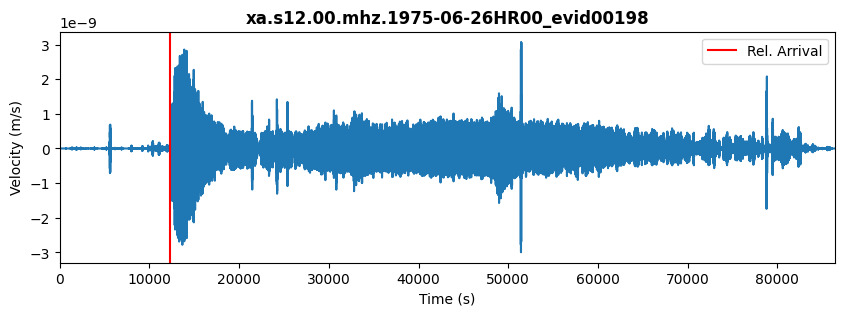

In [ ]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

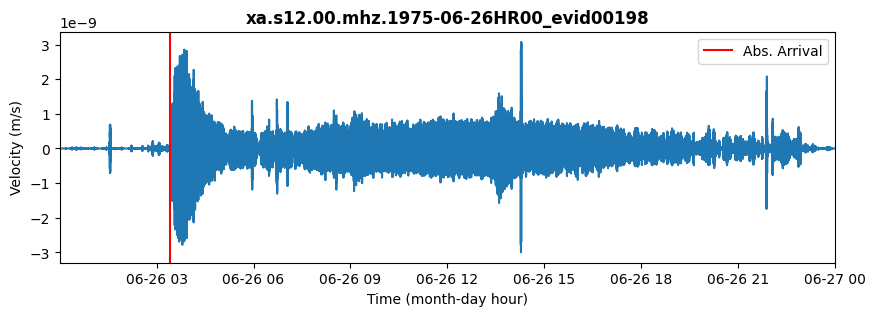

In [ ]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file.

In [ ]:
data_directory = '/content/drive/My Drive/NASA 2024 Space Apps Challenge Seismic/ColabSpaceApps2024/data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1975-06-26T00:00:00.542000Z - 1975-06-27T00:00:01.447660Z | 6.6 Hz, 572407 samples

In [ ]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1975-06-26T00:00:00.542000Z
         endtime: 1975-06-27T00:00:01.447660Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572407
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [ ]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

12239.458

### Plot the trace and mark the arrival!

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s12.00.mhz.1975-06-26HR00_evid00198')

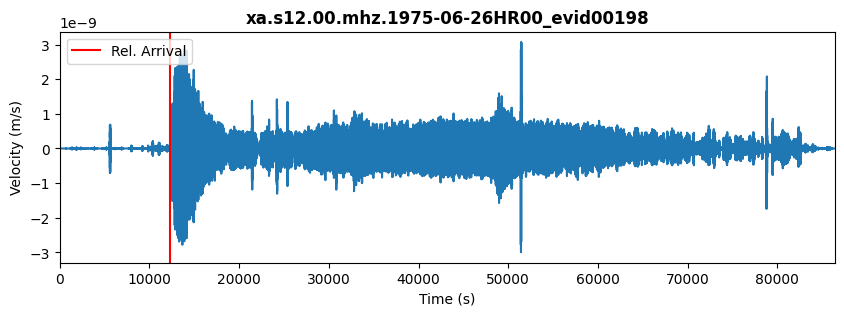

In [ ]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

There are multiple ways that we can do the absolute time using datetime, here is a simple way using the `.timedelta` method

Text(0.5, 1.0, 'xa.s12.00.mhz.1975-06-26HR00_evid00198')

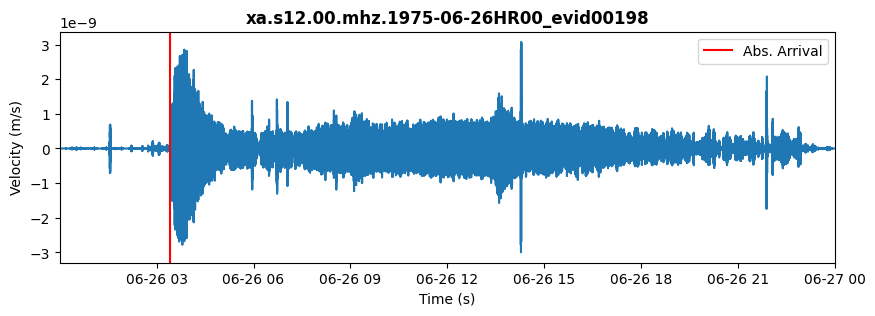

In [ ]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')


It's completely up to you whether to work with the CSV file or the miniseed files. We recommend working with the miniseed file as it's a bit faster to run.

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz.

In [32]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 3

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [33]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

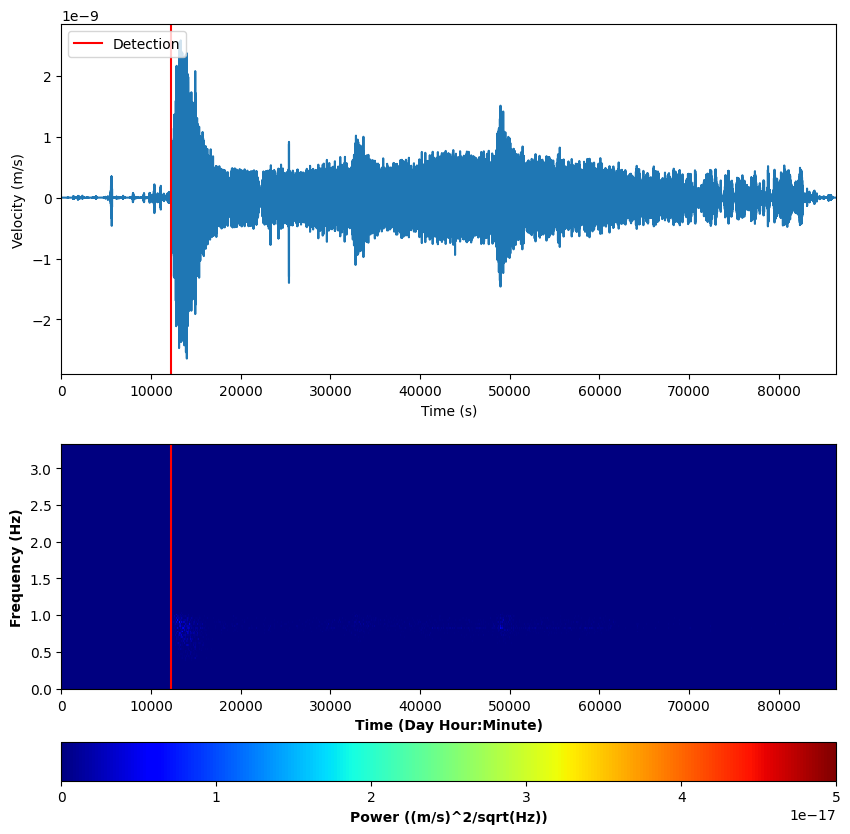

In [34]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

Kalman filter based thresholding for STA/LTA thresholding function:
Different ways to optimize the STA/LTA method:
1) Signal Smoothing
2) Dynamic Model
3) State Estimation
4) Adaptive Thresholding

In [ ]:
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.process_variance = process_variance  # Process variance
        self.measurement_variance = measurement_variance  # Measurement variance
        self.posteri_estimate = 0.0  # Initial estimate
        self.posteri_error_estimate = 1.0  # Initial error estimate

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

        return self.posteri_estimate

working code on adaptive thresholding: need to improve

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(12,3))
# ax.plot(tr_times,detection)
# ax.set_xlim([min(tr_times),max(tr_times)])
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Characteristic function')
# # Plot results

# Sample short-term average / long-term average (STA/LTA) detection algorithm

A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. If the data contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection.

Text(0, 0.5, 'Characteristic function')

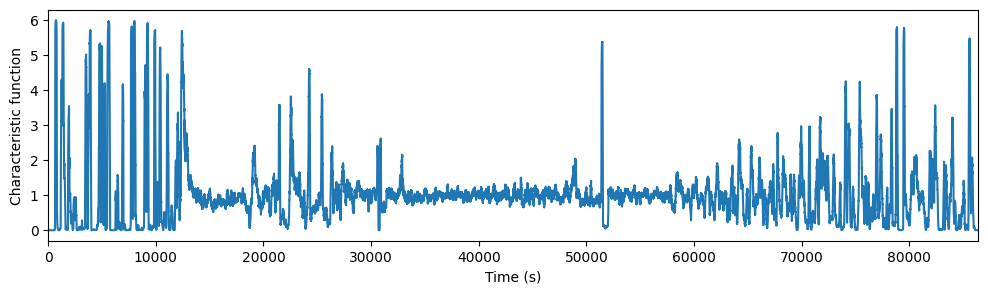

In [43]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import bandpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 100
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

In [29]:


# print(sig_var)

# Initialize Kalman filter
# kf = KalmanFilter(process_variance=1e-5, measurement_variance=0.1)
kf = KalmanFilter(process_variance=1e-4, measurement_variance=1e-6)

filtered_signal = []

# Apply Kalman filter
for measurement in signal:
    filtered_value = kf.update(measurement)
    filtered_signal.append(filtered_value)

# Convert to numpy array
filtered_signal = np.array(filtered_signal)



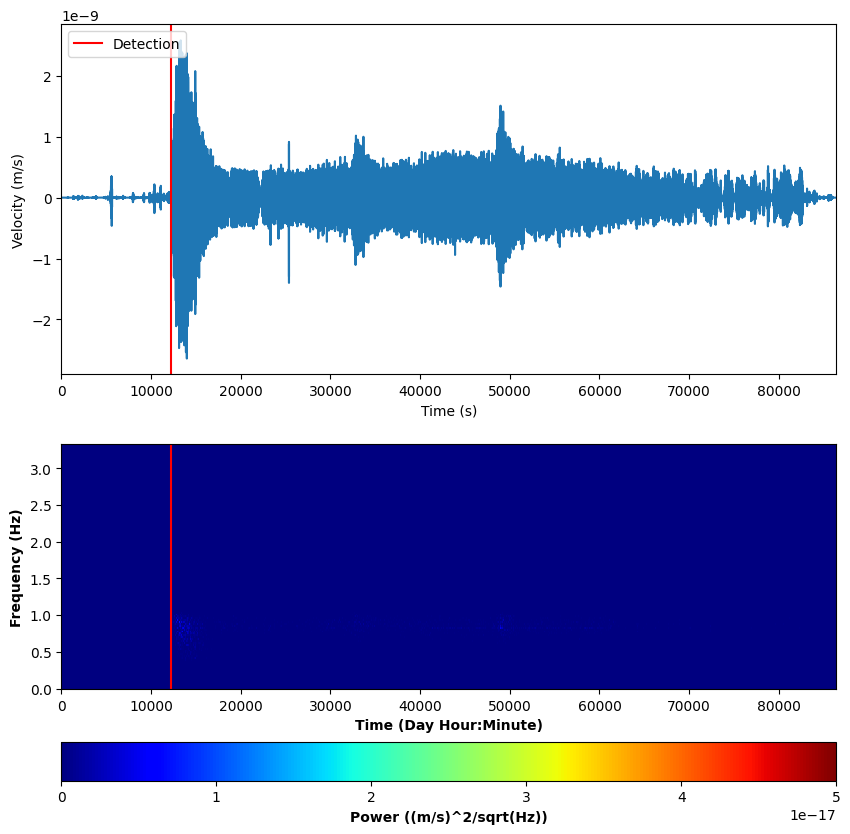

In [30]:
# plt.figure(figsize=(10, 5))
# plt.plot(signal, label='Original Signal', alpha=0.5)
# plt.plot(filtered_signal, label='Kalman Filtered Signal', color='orange')
# # plt.plot(events, label='Detected Events', color='red')
# plt.legend()
# plt.title('Kalman Filtering and STA/LTA Detection')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.show()
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, filtered_signal, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins.
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends.

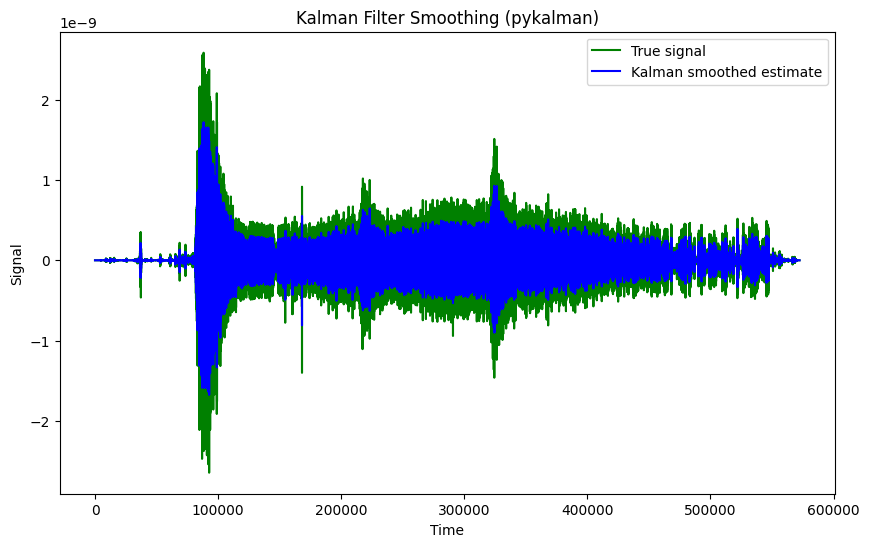

In [103]:
# Simulate a noisy signal
# np.random.seed(42)
time = np.linspace(0, 10, 100)  # Time points
true_signal = tr_data_filt      # True signal (sinusoidal)
# noisy_signal = true_signal + np.random.normal(0, 0.1, len(true_signal))  # Noisy observations
noisy_signal = true_signal  # Noisy observations


# Define Kalman filter parameters
kf = KalmanFilter(
    transition_matrices=np.array([[1]]),  # State transition matrix (A)
    observation_matrices=np.array([[1]]),  # Observation matrix (C)
    transition_covariance=np.array([[0.1]]),  # Process noise (Q)
    observation_covariance=np.array([[0.1]]),  # Measurement noise (R)
    initial_state_mean=np.array([0]),  # Initial estimate of the state
    initial_state_covariance=np.array([[1]])  # Initial state covariance (P0)
)

# Apply Kalman filter to smooth the noisy signal
smoothed_state_means, smoothed_state_covariances = kf.smooth(noisy_signal)

# # Plot the noisy signal, true signal, and Kalman smoothed signal
# plt.figure(figsize=(10, 6))
# plt.plot(time, noisy_signal, 'r.', label='Noisy observations')
# plt.plot(time, true_signal, 'g-', label='True signal')
# plt.plot(time, smoothed_state_means, 'b-', label='Kalman smoothed estimate')
# plt.legend()
# plt.title('Kalman Filter Smoothing (pykalman)')
# plt.xlabel('Time')
# plt.ylabel('Signal')
# plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(noisy_signal[1:1000], 'r.', label='Noisy observations')
plt.plot(true_signal, 'g-', label='True signal')
plt.plot(smoothed_state_means, 'b-', label='Kalman smoothed estimate')
plt.legend()
plt.title('Kalman Filter Smoothing (pykalman)')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()


(572407,)
795


Text(0, 0.5, 'Characteristic function')

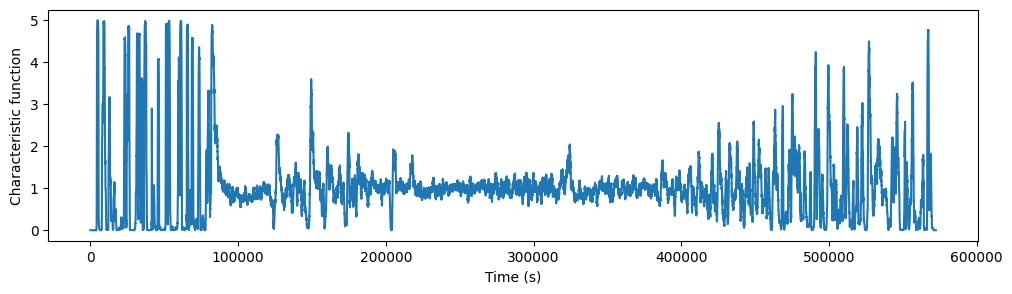

In [105]:
# from obspy.signal.invsim import cosine_taper
# from obspy.signal.filter import bandpass
# from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data

print(smoothed_state_means.shape)
print(int(sta_len * df))
# If it's a 2D array, flatten it to 1D
if len(smoothed_state_means.shape) > 1:
    smoothed_state_means = smoothed_state_means.ravel()  # Convert to 1D array

cft = classic_sta_lta(smoothed_state_means, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(cft)
# ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

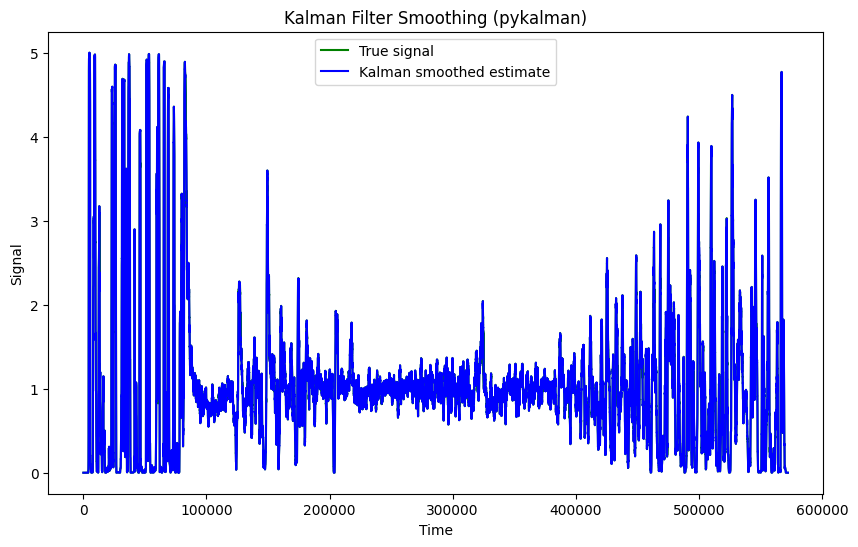

In [106]:
# Simulate a noisy signal
# np.random.seed(42)
time = np.linspace(0, 10, 100)  # Time points
true_signal_cft = cft    # True signal (sinusoidal)
# noisy_signal = true_signal + np.random.normal(0, 0.1, len(true_signal))  # Noisy observations
noisy_signal_cft = cft  # Noisy observations


# Define Kalman filter parameters
kf = KalmanFilter(
    transition_matrices=np.array([[1]]),  # State transition matrix (A)
    observation_matrices=np.array([[1]]),  # Observation matrix (C)
    transition_covariance=np.array([[0.1]]),  # Process noise (Q)
    observation_covariance=np.array([[0.1]]),  # Measurement noise (R)
    initial_state_mean=np.array([0]),  # Initial estimate of the state
    initial_state_covariance=np.array([[1]])  # Initial state covariance (P0)
)

# Apply Kalman filter to smooth the noisy signal
smoothed_state_means_cft, smoothed_state_covariances_cft = kf.smooth(noisy_signal_cft)

# # Plot the noisy signal, true signal, and Kalman smoothed signal
# plt.figure(figsize=(10, 6))
# plt.plot(time, noisy_signal, 'r.', label='Noisy observations')
# plt.plot(time, true_signal, 'g-', label='True signal')
# plt.plot(time, smoothed_state_means, 'b-', label='Kalman smoothed estimate')
# plt.legend()
# plt.title('Kalman Filter Smoothing (pykalman)')
# plt.xlabel('Time')
# plt.ylabel('Signal')
# plt.show()

plt.figure(figsize=(10, 6))
# plt.plot(noisy_signal[1:1000], 'r.', label='Noisy observations')
plt.plot(true_signal_cft, 'g-', label='True signal')
plt.plot(smoothed_state_means_cft, 'b-', label='Kalman smoothed estimate')
plt.legend()
plt.title('Kalman Filter Smoothing (pykalman)')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()


In [ ]:
# # Define the parameter grid for STA and LTA
# param_grid = {'STA': [0.5, 1, 2, 5], 'LTA': [10, 20, 30, 60]}

# # Kalman filter implementation or use a library like pykalman
# def apply_kalman_filter(signal):
#     # Placeholder for Kalman filter logic
#     return filtered_signal

# # Function to calculate performance
# def calculate_performance(signal, STA, LTA):
#     # Apply Kalman filter
#     filtered_signal = apply_kalman_filter(signal)

#     # Compute STA/LTA and performance metrics
#     # (Implement STA/LTA calculations and event detection)

#     return performance_metric

# # Perform grid search
# best_params = None
# best_performance = -np.inf

# for params in ParameterGrid(param_grid):
#     performance = calculate_performance(signal, params['STA'], params['LTA'])
#     if performance > best_performance:
#         best_performance = performance
#         best_params = params

# print(f"Best STA/LTA: {best_params}, Best Performance: {best_performance}")


In [ ]:
# # Define the objective function
# def objective(params):
#     STA, LTA = params
#     # Apply Kalman filter
#     # filtered_signal = apply_kalman_filter(signal)
#     # Calculate the performance metric using the current STA and LTA
#     performance = calculate_performance(filtered_signal, STA, LTA)
#     def calculate_performance(signal, STA, LTA):
#     # Perform some operations with STA and LTA on the signal
#     # (This part of your code likely handles the actual Kalman filtering and STA/LTA process)

#     # Let's assume that `filtered_signal` is the result of your Kalman filtering
#     filtered_signal = some_kalman_filter_function(signal, STA, LTA)

#     # Calculate performance metric (e.g., RMSE)
#     performance_metric = np.sqrt(np.mean((signal - filtered_signal)**2))

#     return performance_metric

#     return -performance  # Minimize the negative performance

# # Define the search space for STA and LTA
# space = [(0.5, 5.0),  # STA range
#          (10.0, 60.0)] # LTA range

# # Perform Bayesian optimization
# result = gp_minimize(objective, space, n_calls=50, random_state=42)

# print(f"Best STA: {result.x[0]}, Best LTA: {result.x[1]}, Best Performance: {-result.fun}")

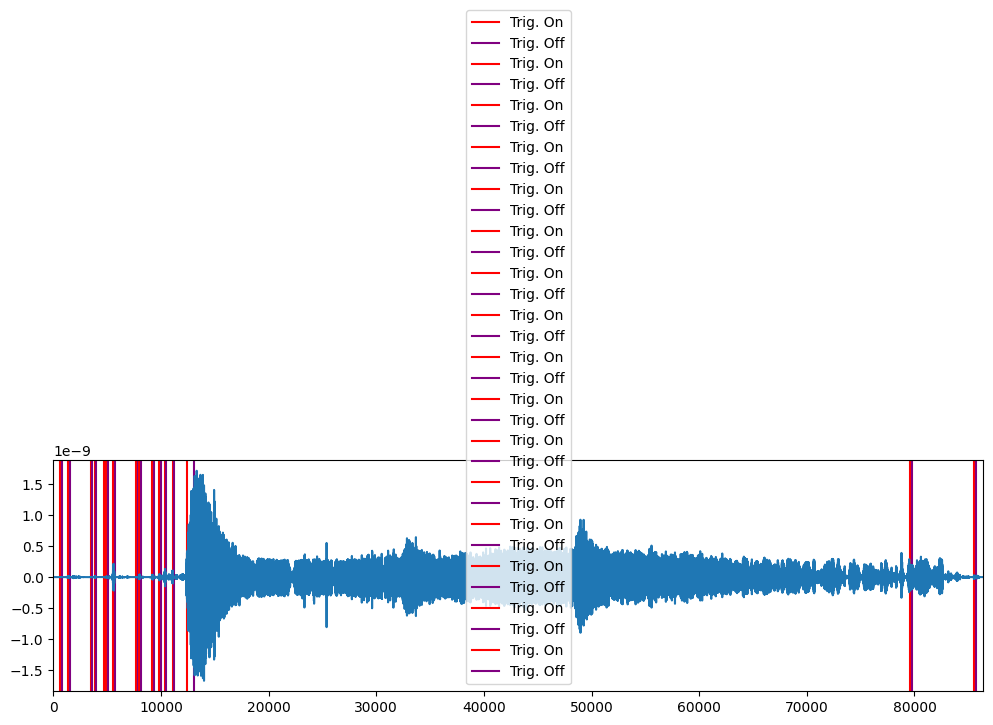

In [109]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4.3
thr_off = 1.5
on_off = np.array(trigger_onset(smoothed_state_means_cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on".
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,smoothed_state_means)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

**Note**: You do not have to worry about marking the end of the seismic trace (as you can see, even for us it's not very accurate!). For this challenge, all we care about is the start of the seismic waveform.

## Sample detection export into a catalog!
There are many ways to do this, but we'll show a way to do it using pandas.

In [25]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)

# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-06-26T00:10:59.409925,85571.924528
1,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-06-26T00:21:59.032566,85571.924528
2,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-06-26T00:58:45.523132,85571.924528
3,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-06-26T01:04:14.126906,85571.924528
4,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-06-26T01:19:13.598604,85571.924528


This can then be exported to a csv using:

`detect_df.to_csv('output/path/catalog.csv', index=False)`

# Download additional data from Earth-based stations

You may find that you need to download additional data from Earth stations to supplement your models and algorithms. We recommend that you download any events from IRIS (Incorporated Research Institutations for Seismology).

https://www.iris.edu/hq/

**Note**: The organization has been recently renamed to SAGE (Seismological Facility for the Advancement of Geoscience), but all the previous links should still work.

They maintain and curate data from seismic stations all around the world. There are many different ways to get data from them, but I recommend using the utility *PyWeed*:

https://ds.iris.edu/ds/nodes/dmc/software/downloads/pyweed/

We can use the utility to select seismic stations and the earthquake data (or **events**) recorded at those stations.

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/station_data_location.png" alt="Drawing" style="width: 1200px;">

For this test case, let's download all of the earthquakes magnitude 3 and above that are within 1 degree distance (approximately 110 km) from a site called PFO (Pinon Flat Observatory) in California. **Location** is a number designating the instrument at a particular site (sites may have multiple instruments), and **channel** is an IRIS code that specifies instrument information.

In short, the first latter refers to the samplerate of the instrument (how many data points it records per second), the second to the type of instrument (certain types of seismometers are better at recording nearby earthquakes while others are more suited for distant earthquakes), and the last to the directional component being recored (most seismometers will record motion across two horizontal directions and the vertical). We will pick the channel HHZ, which refers to a (H) high-samplerate (100 samples per second) (H) strong-motion accelerometer (best resolution for nearby strong earthquakes) recording in the (Z) vertical direction. Once you've selected all the earthquakes, you can download the traces.

An earthquake is composed of the following types of waves (in order): pressure (P-wave), shear (S-wave), and surface (Rayleigh and Love). For our challenge, we are only interested in identifying the start of the earthquake. The IRIS dataset contains P-wave arrivals (onset of the P-wave at the seismometer) for each earthquake. In order to get noise prior to the earthquake arrival, we pick our data traces to span 101 seconds before to 60 seconds past the P-wave arrival:


<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/selected_seismograms.png" alt="Drawing" style="width: 1200px;">


As you can see from the output list, some of the earthquakes don't record any earthquake data (3.4 Ml 2005-08-31) and others have an incorrect P-wave arrival time (4.0 Ml 2005-08-31). Make sure to go through the earthquakes and remove those types of events from the waveform preview prior to download. For output file type, choose miniseed to match the planetary data (SAC is probably fine too, but the file sizes tend to be a bit bigger).

## Thank you very much for being a part of this challenge! Good luck!!!